## KNN
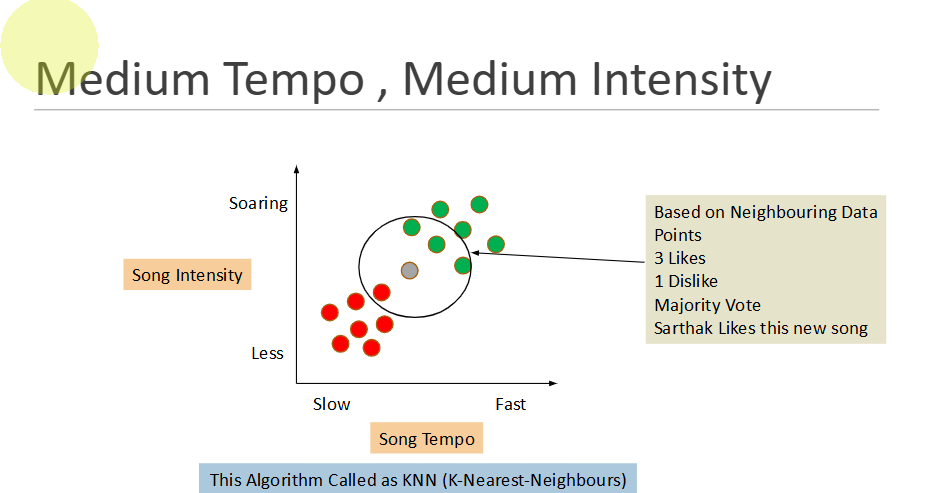 

In [1]:
# ignore non harmful warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
df.shape

(200, 6)

## Perform basic data quality checks

In [5]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [6]:
df.duplicated().sum()

0

## There are no missing values and duplicated rows in this dataset

## Separate X and Y features
Target: Y : Drug

In [7]:
X = df.drop(columns='Drug')
Y = df[["Drug"]]

In [8]:
X.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [9]:
Y.head()

,Drug
0,DrugY
1,drugC
2,drugC
3,drugX
4,DrugY


In [10]:
Y.value_counts()

Drug 
DrugY    91
drugX    54
drugA    23
drugB    16
drugC    16
Name: count, dtype: int64

<Axes: xlabel='Drug'>

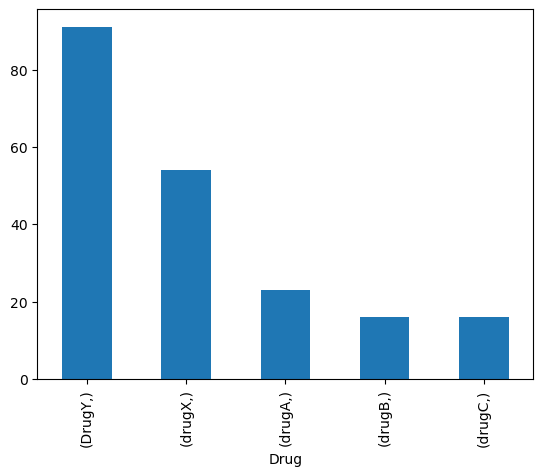

In [11]:
Y.value_counts().plot(kind='bar')

## Data Preprocessing and Data Cleaning

In [15]:
df['BP'].unique()

array(['HIGH', 'LOW', 'NORMAL'], dtype=object)

In [16]:
df['Cholesterol'].unique()

array(['HIGH', 'NORMAL'], dtype=object)

In [13]:
cat = list(X.columns[X.dtypes=="object"])
con=list(X.columns[X.dtypes!="object"])

In [12]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [14]:
num_pipe = make_pipeline(
    (SimpleImputer(strategy='mean')),
    StandardScaler()
)

In [17]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore',sparse_output=False,drop="first")
)

In [18]:
pre = ColumnTransformer([
    ('cat',cat_pipe,cat),
    ('num',num_pipe,con)
]
).set_output(transform='pandas')

In [19]:
pre

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'BP', 'Cholesterol']),
                                ('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Na_to_K'])])

In [20]:
X_pre = pre.fit_transform(X)
X_pre.head()

,cat__Sex_M,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_NORMAL,num__Age,num__Na_to_K
0,0.0,0.0,0.0,0.0,-1.291591,1.286522
1,1.0,1.0,0.0,0.0,0.162699,-0.415145
2,1.0,1.0,0.0,0.0,0.162699,-0.828558
3,0.0,0.0,1.0,0.0,-0.988614,-1.149963
4,0.0,1.0,0.0,0.0,1.011034,0.271794


## Apply train test split
split the dataset into training and testing

In [21]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X_pre,Y,train_size=0.8,random_state=21)

In [22]:
xtrain.head()

,cat__Sex_M,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_NORMAL,num__Age,num__Na_to_K
176,1.0,0.0,0.0,1.0,0.223294,-0.782485
111,0.0,0.0,1.0,1.0,0.162699,-1.304698
114,0.0,0.0,1.0,1.0,-1.473377,-0.944158
14,0.0,0.0,1.0,0.0,0.344485,-0.469268
106,1.0,0.0,1.0,0.0,-1.352186,-0.573350


In [23]:
xtest.head()

,cat__Sex_M,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_NORMAL,num__Age,num__Na_to_K
144,1.0,0.0,0.0,0.0,-0.322065,-0.891007
9,1.0,1.0,0.0,1.0,-0.079683,0.455672
17,1.0,0.0,0.0,0.0,-0.079683,-0.293162
20,1.0,1.0,0.0,1.0,0.768653,0.422366
45,0.0,0.0,1.0,1.0,1.314011,-1.107081


In [24]:
ytrain.head()

,Drug
176,drugA
111,drugX
114,drugX
14,drugX
106,drugX


In [25]:
ytest.head()

,Drug
144,drugA
9,DrugY
17,drugA
20,DrugY
45,drugX


## Model Building
    1. KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier
model1 = KNeighborsClassifier(n_neighbors=45)
model1.fit(xtrain,ytrain)

KNeighborsClassifier(n_neighbors=45)

In [27]:
model1.score(xtrain,ytrain)

0.75625

In [28]:
model1.score(xtest,ytest)

0.725

## Hyperparameter tuning

In [29]:
params = {
    "n_neighbors":[10,20,30,40,50]
}

In [30]:
from sklearn.model_selection import RandomizedSearchCV
model_knn = KNeighborsClassifier()
rscv = RandomizedSearchCV(estimator=model_knn,param_distributions=params,cv=3,scoring='f1_macro')
rscv.fit(xtrain,ytrain)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [10, 20, 30, 40, 50]},
                   scoring='f1_macro')

In [31]:
rscv.best_params_

{'n_neighbors': 10}

In [32]:
rscv.best_score_

0.8159439814766198

In [33]:
best_knn = rscv.best_estimator_

## Model evaluation

In [34]:
best_knn.score(xtrain,ytrain)

0.9375

In [35]:
best_knn.score(xtest,ytest)

0.775

In [36]:
ypred_test = best_knn.predict(xtest)
ypred_test[:5]

array(['drugA', 'DrugY', 'drugA', 'DrugY', 'drugX'], dtype=object)

In [37]:
ytest.head()

,Drug
144,drugA
9,DrugY
17,drugA
20,DrugY
45,drugX


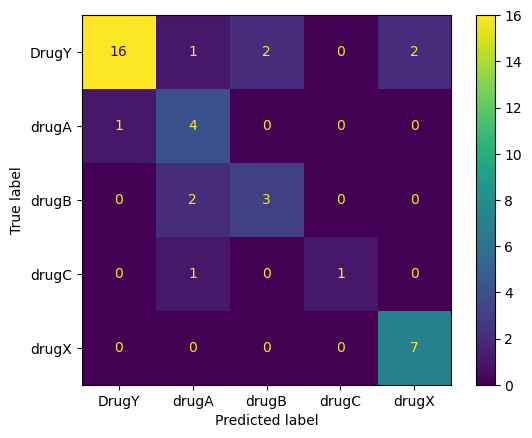

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
ConfusionMatrixDisplay.from_estimator(best_knn,xtest,ytest)

In [40]:
print(classification_report(ytest,ypred_test))

              precision    recall  f1-score   support

       DrugY       0.94      0.76      0.84        21
       drugA       0.50      0.80      0.62         5
       drugB       0.60      0.60      0.60         5
       drugC       1.00      0.50      0.67         2
       drugX       0.78      1.00      0.88         7

    accuracy                           0.78        40
   macro avg       0.76      0.73      0.72        40
weighted avg       0.82      0.78      0.78        40

